In [10]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset import CardiacDataset
from model import UNet

In [2]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [3]:
# Create the dataset objects
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images


In [71]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [72]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice

In [38]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import numpy as np


class AtriumSegmentation(pl.LightningModule):
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = UNet().cuda()
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        if batch_idx % 50 == 0:
            self.log_images(mri, pred, mask, "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss, on_step=True, on_epoch=True, prog_bar=True)
        
        if batch_idx % 2 == 0:
            self.log_images(mri, pred, mask, "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0].cpu(), cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0].cpu() == 0, mask[0][0].cpu())
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0].cpu(), cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0].cpu() == 0, pred[0][0].cpu())
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [73]:
torch.manual_seed(0)
model = AtriumSegmentation().cuda()
print(next(model.parameters()).device)

cuda:0


In [74]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=3,
    mode='min')

In [75]:
print(torch.cuda.is_available())

True


In [70]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

class GPUVerificationCallback(pl.Callback):
    def on_train_start(self, trainer, pl_module):
        print(f"Is CUDA available: {torch.cuda.is_available()}")
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device count: {torch.cuda.device_count()}")
        print(f"Device name: {torch.cuda.get_device_name(0)}")
        print(f"Model device: {next(pl_module.parameters()).device}")

# Add this to your trainer initialization
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=15,
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
    callbacks=checkpoint_callback
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [76]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 Ti


In [77]:
print(next(model.parameters()).device)

cuda:0


In [78]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | UNet     | 7.8 M  | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2:  87%|████████▋ | 211/242 [05:07<00:45,  0.69it/s, v_num=2, Train Dice_step=1.000, Val Dice_step=1.000, Val Dice_epoch=1.000, Train Dice_epoch=1.000]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [46]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [84]:
model = AtriumSegmentation.load_from_checkpoint(r"C:\Users\hp\Desktop\Medical image analysis\Atrium_segmentation\logs\lightning_logs\version_1\checkpoints\epoch=0-step=242.ckpt")

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [86]:
from tqdm import tqdm
import torch

# Assuming val_dataset is a DataLoader or similar iterable

preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

  0%|          | 1/339 [00:00<01:01,  5.49it/s]

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

 82%|████████▏ | 278/339 [00:08<00:01, 30.91it/s]

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

100%|██████████| 339/339 [00:10<00:00, 31.13it/s]

[WindowsPath('Preprocessed/val/17/data/0.npy'), WindowsPath('Preprocessed/val/17/data/1.npy'), WindowsPath('Preprocessed/val/17/data/10.npy'), WindowsPath('Preprocessed/val/17/data/100.npy'), WindowsPath('Preprocessed/val/17/data/101.npy'), WindowsPath('Preprocessed/val/17/data/102.npy'), WindowsPath('Preprocessed/val/17/data/103.npy'), WindowsPath('Preprocessed/val/17/data/104.npy'), WindowsPath('Preprocessed/val/17/data/105.npy'), WindowsPath('Preprocessed/val/17/data/106.npy'), WindowsPath('Preprocessed/val/17/data/107.npy'), WindowsPath('Preprocessed/val/17/data/108.npy'), WindowsPath('Preprocessed/val/17/data/109.npy'), WindowsPath('Preprocessed/val/17/data/11.npy'), WindowsPath('Preprocessed/val/17/data/110.npy'), WindowsPath('Preprocessed/val/17/data/111.npy'), WindowsPath('Preprocessed/val/17/data/112.npy'), WindowsPath('Preprocessed/val/17/data/113.npy'), WindowsPath('Preprocessed/val/17/data/114.npy'), WindowsPath('Preprocessed/val/17/data/115.npy'), WindowsPath('Preprocessed

In [87]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.)

In [88]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.0


In [98]:
subject = Path("Task02_Heart/imagesTs/la_002.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [99]:
# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data

In [100]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [101]:
standardized_scan.shape

(256, 256, 140)

In [102]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

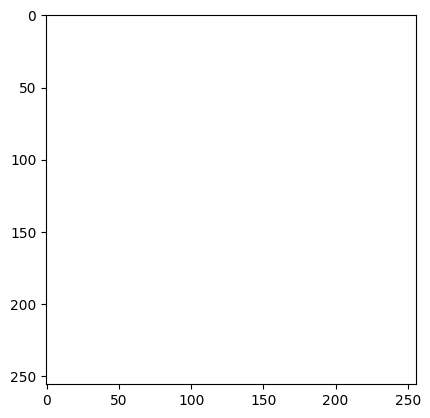

In [96]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [103]:
animation.save('animation.gif', writer='pillow')